### Preprocess data

In [ ]:
import tensorflow as tf

file_URL = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'

path_to_downloaded_file = tf.keras.utils.get_file('/tmp/shakespeare.txt', file_URL)
with open(path_to_downloaded_file) as f:
    shakespeare_text = f.read()

1122304/1115394 [==============================] - 0s 0us/step


In [ ]:
print('Number of characters: ', len(shakespeare_text))
print()
print(shakespeare_text[:100])

Number of characters:  1115394

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np

# train a tokenizer
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

# encode texts
encoded = np.array(tokenizer.texts_to_sequences([shakespeare_text])[0])

# train-test split
n_chars = tokenizer.document_count
train_size = (n_chars * 90 // 100)
X_train = encoded[:train_size]

In [ ]:
window_size = 100
batch_size = 32
n_ids = len(tokenizer.word_index)

dataset = tf.data.Dataset.from_tensor_slices(X_train)
dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
dataset = dataset.map(lambda X_batch, y_batch: (X_batch, tf.one_hot(y_batch, depth=n_ids)))
dataset = dataset.shuffle(buffer_size=10000)
dataset = dataset.repeat().batch(batch_size).prefetch(1)

In [ ]:
for X_batch, y_batch in dataset.take(1):
    print(X_batch.shape, y_batch.shape)

(32, 100) (32, 39)


### Build char-level language model

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(n_ids, activation='softmax')                 
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
gru (GRU)                    (None, None, 128)         50304     
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense (Dense)                (None, 39)                5031      
Total params: 154,407
Trainable params: 154,407
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss=tf.keras.losses.Huber(), optimizer='adam')
history = model.fit(dataset, 
                    epochs=20,
                    steps_per_epoch=train_size // batch_size)

Epoch 1/20
31370/31370 [==============================] - 388s 12ms/step - loss: 0.0097
Epoch 2/20
31370/31370 [==============================] - 378s 12ms/step - loss: 0.0087
Epoch 3/20
31370/31370 [==============================] - 377s 12ms/step - loss: 0.0084
Epoch 4/20
31370/31370 [==============================] - 373s 12ms/step - loss: 0.0083
Epoch 5/20
31370/31370 [==============================] - 373s 12ms/step - loss: 0.0082
Epoch 6/20
31370/31370 [==============================] - 374s 12ms/step - loss: 0.0081
Epoch 7/20
31370/31370 [==============================] - 381s 12ms/step - loss: 0.0081
Epoch 8/20
31370/31370 [==============================] - 375s 12ms/step - loss: 0.0080
Epoch 9/20
31370/31370 [==============================] - 366s 12ms/step - loss: 0.0080
Epoch 10/20
31370/31370 [==============================] - 364s 12ms/step - loss: 0.0080
Epoch 11/20
31370/31370 [==============================] - 371s 12ms/step - loss: 0.0080
Epoch 12/20
31370/31370 [=====

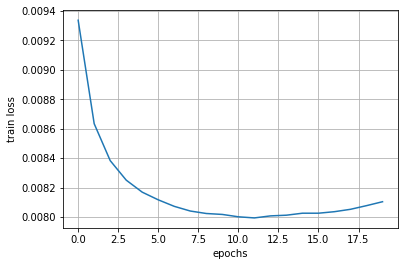

In [ ]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
n_epochs = history.epoch

plt.xlabel('epochs')
plt.ylabel('train loss')
plt.grid(True)
plt.plot(n_epochs, train_loss)

Training loss began to increase from `epoch=10`, hinting that the model is overfitting to the training data. 

### Generate text

In [ ]:
text_length = 50
text = 'the'

for _ in range(text_length):

    x = tokenizer.texts_to_sequences([text])[0]
    x = tf.expand_dims(x, axis=0)

    y_proba = model(x)

    idx = tf.argmax(y_proba, axis=1).numpy()
    c = tokenizer.sequences_to_texts([idx])
    text += c[0]

print(text)

the:
so will the countent that he is not the countent
